# Model Training

In [100]:
# data manipulation libraries
import pandas as pd
import numpy as np

# custom project libraries
from utils.wine_review_utils import load_augmented_data, RATINGS

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Load Augmented data

In [101]:
reviews = load_augmented_data()
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
Index: 98460 entries, 0 to 129970
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   winery              98460 non-null  object 
 1   variety             98460 non-null  object 
 2   year                98460 non-null  int64  
 3   country             98460 non-null  object 
 4   price               91633 non-null  float64
 5   taster_name         98460 non-null  object 
 6   description         98460 non-null  object 
 7   points              98460 non-null  int64  
 8   rating              98460 non-null  object 
 9   description_length  98460 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 8.3+ MB


,winery,variety,year,country,price,taster_name,description,points,rating,description_length
0,Nicosia,White Blend,2013,Italy,NaN,Kerin O’Keefe,"Aromas include tropical fruit, broom, brimston...",87,very good,172
1,Quinta dos Avidagos,Portuguese Red,2011,Portugal,15.0,Roger Voss,"This is ripe and fruity, a wine that is smooth...",87,very good,227
2,Rainstorm,Pinot Gris,2013,US,14.0,Paul Gregutt,"Tart and snappy, the flavors of lime flesh and...",87,very good,186
3,St. Julian,Riesling,2013,US,13.0,Alexander Peartree,"Pineapple rind, lemon pith and orange blossom ...",87,very good,199
4,Sweet Cheeks,Pinot Noir,2012,US,65.0,Paul Gregutt,"Much like the regular bottling from 2012, this...",87,very good,249


## Training/Test Data Split

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# features
X = reviews[['variety', 'country', 'year', 'description_length', 'description']]

# target
ohe = OneHotEncoder()
y = ohe.fit_transform(reviews.rating.to_frame())
Y = pd.DataFrame(y.todense(), index=reviews.index, columns=ohe.categories_)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=42)

In [103]:
# inspect encoded target
Y.head()

,acceptable,classic,excellent,good,superb,very good
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0


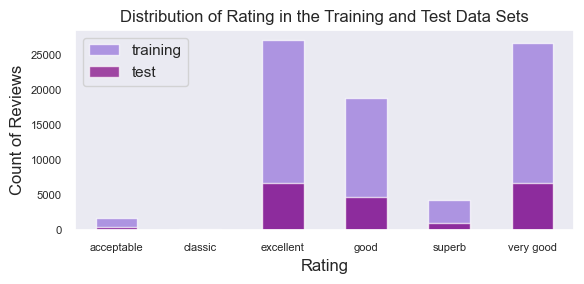

In [104]:
# check the distribution of the target variable
__y_train = reviews.loc[X_train.index, 'rating']
__y_test = reviews.loc[X_test.index, 'rating']

fig = plt.figure(figsize=(6,3))
pd.Series(__y_train).value_counts(normalize=False).sort_index().plot(kind='bar', color='mediumpurple', alpha=0.7, label='training')
pd.Series(__y_test).value_counts(normalize=False).sort_index().plot(kind='bar', color='purple', alpha=0.7, label='test')
plt.title("Distribution of Rating in the Training and Test Data Sets")
plt.xlabel("Rating")
plt.ylabel("Count of Reviews")
plt.xticks(plt.xticks()[0], labels=['acceptable', 'classic', 'excellent', 'good', 'superb', 'very good'], fontsize=8, rotation=0)
plt.yticks(fontsize=8)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Baseline Model

In [105]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import time

# define the baseline model
lr_pipe = Pipeline([
  ('preprocess', ColumnTransformer([('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['variety', 'country']),
                                    ('scaler', Pipeline([('poly', PolynomialFeatures(degree=2)), ('scaler', MinMaxScaler())]), ['year', 'description_length']),      
                                  ])
  ),
  ('lr', LogisticRegression(max_iter=500, C=.5, solver='saga')),
])

# fit the baseline model
start = time.perf_counter()
lr_pipe.fit(X_train.drop('description', axis=1), __y_train)
duration = time.perf_counter()-start

# evaluate performance
accuracy_train = lr_pipe.score(X_train.drop('description', axis=1), __y_train)
accuracy_test = lr_pipe.score(X_test.drop('description', axis=1), __y_test)

print(f'Accuracy on training data: {accuracy_train:.1%}')
print(f'Accuracy on test data: {accuracy_test:.1%}')

Accuracy on training data: 52.5%
Accuracy on test data: 52.1%


In [106]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# the target classes
ratings = ['acceptable', 'good', 'very good', 'excellent', 'superb', 'classic']

# predictions on test data
y_preds = lr_pipe.predict(X_test)
y_pred_prob = lr_pipe.predict_proba(X_test)

# confusion matrix
conf_matrix = confusion_matrix(ohe.inverse_transform(y_test), y_preds, normalize='pred', labels=ratings)

# classification report
print(classification_report(ohe.inverse_transform(y_test), y_preds, labels=ratings, zero_division=0))

              precision    recall  f1-score   support

  acceptable       0.81      0.06      0.11       438
        good       0.54      0.54      0.54      4719
   very good       0.47      0.46      0.46      6668
   excellent       0.56      0.67      0.61      6779
      superb       0.53      0.08      0.14      1065
     classic       0.00      0.00      0.00        23

    accuracy                           0.52     19692
   macro avg       0.48      0.30      0.31     19692
weighted avg       0.52      0.52      0.50     19692



In [107]:
result_baseline = (duration, accuracy_train, accuracy_test, conf_matrix, y_preds, y_pred_prob)

## Feature Engineering

In [108]:
from sklearn.preprocessing import FunctionTransformer
from sentence_transformers import SentenceTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures

model = SentenceTransformer('all-mpnet-base-v2')
to_embeddings = lambda series: model.encode(series.to_list(), normalize_embeddings=False, show_progress_bar=True, device='mps')

to_features_out = lambda self, cols: [f'{i}' for i in range(768)]

transformer = ColumnTransformer([('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['variety', 'country']),
                                 ('scaler', Pipeline([('poly', PolynomialFeatures(degree=2)), ('scaler', MinMaxScaler())]), ['year', 'description_length']),
                                 ('embeds', Pipeline([('encode', FunctionTransformer(to_embeddings, feature_names_out=to_features_out)),
                                                      ('scaler', MinMaxScaler()),
                                                    ]), 'description'),
                                ])
transformer

ColumnTransformer(transformers=[('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist'),
                                 ['variety', 'country']),
                                ('scaler',
                                 Pipeline(steps=[('poly', PolynomialFeatures()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['year', 'description_length']),
                                ('embeds',
                                 Pipeline(steps=[('encode',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x483f69580>,
                                                                      func=<function <lambda> at 0x5a982bd80>)),
                                                 ('scaler', MinMaxScaler())]),
                                 'description')])

## Preprocess the Data

Because of the size of the data set and how long it takes to preprocess, we will transform the features once, and then fit and tune the classifiers.

In [109]:
# fit the transform on the training data
X_train_transformed = transformer.fit_transform(X_train)
print('training features', X_train_transformed.shape)

# transform the test data using the transform fitted to the training data
X_test_transformed = transformer.transform(X_test)
print('test features', X_test_transformed.shape)

# inspect the transformed data
pd.DataFrame(X_train_transformed, columns=transformer.get_feature_names_out(), index=X_train.index).head()

Batches:   0%|          | 0/2462 [00:00<?, ?it/s]

training features (78768, 837)


Batches:   0%|          | 0/616 [00:00<?, ?it/s]

test features (19692, 837)


,ohe__variety_Albariño,ohe__variety_Barbera,ohe__variety_Bordeaux-style Red Blend,ohe__variety_Bordeaux-style White Blend,ohe__variety_Cabernet Franc,ohe__variety_Cabernet Sauvignon,ohe__variety_Carmenère,ohe__variety_Champagne Blend,ohe__variety_Chardonnay,ohe__variety_Chenin Blanc,...,embeds__758,embeds__759,embeds__760,embeds__761,embeds__762,embeds__763,embeds__764,embeds__765,embeds__766,embeds__767
94510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340517,0.610281,0.532095,0.317333,0.730589,0.404157,0.431403,0.491911,0.521209,0.535674
79419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.592357,0.479321,0.434214,0.210388,0.457484,0.348371,0.491605,0.603886,0.363283,0.525615
122892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.668307,0.415319,0.595717,0.597334,0.470710,0.508631,0.466345,0.579676,0.439602,0.358229
45902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.443654,0.500460,0.481269,0.564452,0.556642,0.475039,0.479017,0.600085,0.406183,0.618107
24213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333611,0.408166,0.476922,0.517590,0.532128,0.368484,0.511218,0.574513,0.427325,0.603493


## Neural Network Classifier

In [110]:
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping

def make_neural_classifier(n=1, n_input=X_train_transformed.shape[1], n_classes=len(ohe.categories_[0])):
  inputs = layers.Input(shape=(n_input,))
  for i in range(n):
    x = layers.Dense(128, activation='relu')(inputs if i == 0 else x)
  x = layers.Dense(n_classes, activation='softmax')(x)

  model = Model(inputs, x)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(learning_rate=0.01),
      metrics=['accuracy']
  )
  return model


In [111]:
model = make_neural_classifier()
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 837)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       107,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,038 (422.02 KB)

 Trainable params: 108,038 (422.02 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
callback = EarlyStopping(monitor='accuracy', patience=3)

start = time.perf_counter()
history = model.fit(x=X_train_transformed, y=y_train, validation_data=(X_test_transformed, y_test), epochs=100, batch_size=64, callbacks=[callback])
training_time = time.perf_counter() - start

print(f'neural network training time: {training_time/60:.2f} min.')

Epoch 1/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.4727 - loss: 1.4151 - val_accuracy: 0.5269 - val_loss: 1.0392
Epoch 2/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.5589 - loss: 0.9740 - val_accuracy: 0.5706 - val_loss: 0.9643
Epoch 3/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.5774 - loss: 0.9330 - val_accuracy: 0.5569 - val_loss: 0.9646
Epoch 4/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.5811 - loss: 0.9244 - val_accuracy: 0.5817 - val_loss: 0.9254
Epoch 5/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.5884 - loss: 0.9125 - val_accuracy: 0.6016 - val_loss: 0.8866
Epoch 6/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.5857 - loss: 0.9122 - val_accuracy: 0.5673 - val_loss: 0.9651
Epoch 7/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.5907 - loss: 0.9038 - val_accuracy: 0.5797 - val_loss: 0.9194
Epoch 8/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 

In [113]:
accuracy_train = model.evaluate(x=X_train_transformed, y=y_train, return_dict=True)
accuracy_test = model.evaluate(x=X_test_transformed, y=y_test, return_dict=True)
accuracy_test

2462/2462 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step - accuracy: 0.5951 - loss: 0.8860
616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - accuracy: 0.5964 - loss: 0.8856


{'accuracy': 0.593438982963562, 'loss': 0.8916056156158447}

In [114]:
from sklearn.metrics import accuracy_score

# predictions on test data
y_pred_prob = model.predict(X_test_transformed)
y_pred = np.argmax(y_pred_prob, axis=1)

# reverse coded predictions
y_preds = np.apply_along_axis(lambda v: ohe.categories_[0][v], axis=0, arr=y_pred)
print(f'Accuracy on test data: {accuracy_score(ohe.inverse_transform(y_test), y_preds):.1%}')

# confusion matrix
conf_matrix = confusion_matrix(ohe.inverse_transform(y_test), y_preds, normalize='pred', labels=ratings)

# classification report
print(classification_report(ohe.inverse_transform(y_test), y_preds, labels=ratings, zero_division=0))

616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
Accuracy on test data: 59.3%
              precision    recall  f1-score   support

  acceptable       0.67      0.02      0.04       438
        good       0.56      0.78      0.66      4719
   very good       0.54      0.46      0.50      6668
   excellent       0.67      0.67      0.67      6779
      superb       0.54      0.37      0.44      1065
     classic       0.00      0.00      0.00        23

    accuracy                           0.59     19692
   macro avg       0.50      0.38      0.38     19692
weighted avg       0.59      0.59      0.58     19692



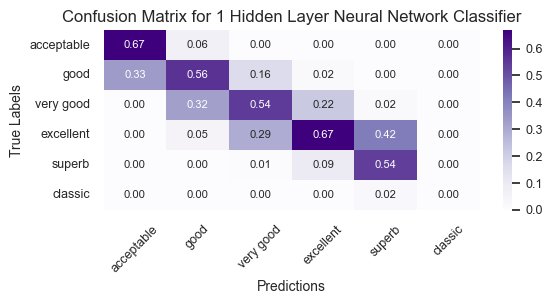

In [115]:
fig = plt.figure(figsize=(6, 3))
ax = sns.heatmap(conf_matrix, xticklabels=ratings, yticklabels=ratings, annot=True, cmap="Purples", fmt=",.2f", annot_kws={"size": 8}, )
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9, rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
ax.set_ylabel('True Labels', fontdict={'size': 10})
ax.set_xlabel('Predictions', fontdict={'size': 10})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=9)
plt.tight_layout()
plt.title('Confusion Matrix for 1 Hidden Layer Neural Network Classifier')
plt.show()

In [116]:
result_nn_1_layer = (training_time, accuracy_train['accuracy'], accuracy_test['accuracy'], conf_matrix, y_preds, y_pred_prob)

## Try Neural Network With More Hidden Layers

In [117]:
model = make_neural_classifier(2)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 837)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       107,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,550 (486.52 KB)

 Trainable params: 124,550 (486.52 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
callback = EarlyStopping(monitor='accuracy', patience=3)

start = time.perf_counter()
history = model.fit(x=X_train_transformed, y=y_train, validation_data=(X_test_transformed, y_test), epochs=100, batch_size=64, callbacks=[callback])
training_time = time.perf_counter() - start

print(f'neural network training time: {training_time/60:.2f} min.')

Epoch 1/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.3958 - loss: 1.3527 - val_accuracy: 0.5852 - val_loss: 0.9363
Epoch 2/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.5680 - loss: 0.9643 - val_accuracy: 0.5874 - val_loss: 0.9232
Epoch 3/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - accuracy: 0.5728 - loss: 0.9470 - val_accuracy: 0.5896 - val_loss: 0.9132
Epoch 4/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.5792 - loss: 0.9332 - val_accuracy: 0.5889 - val_loss: 0.9165
Epoch 5/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.5824 - loss: 0.9275 - val_accuracy: 0.5950 - val_loss: 0.9024
Epoch 6/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.5870 - loss: 0.9185 - val_accuracy: 0.5965 - val_loss: 0.9007
Epoch 7/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - accuracy: 0.5886 - loss: 0.9186 - val_accuracy: 0.5131 - val_loss: 1.0897
Epoch 8/100
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 

In [119]:
accuracy_train = model.evaluate(x=X_train_transformed, y=y_train, return_dict=True)
accuracy_test = model.evaluate(x=X_test_transformed, y=y_test, return_dict=True)
accuracy_test

2462/2462 ━━━━━━━━━━━━━━━━━━━━ 1s 337us/step - accuracy: 0.6036 - loss: 0.8906
616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.6108 - loss: 0.8899


{'accuracy': 0.6047633290290833, 'loss': 0.8966079354286194}

In [120]:
# the target classes
ratings = ['acceptable', 'good', 'very good', 'excellent', 'superb', 'classic']

# predictions on test data
y_pred_prob = model.predict(X_test_transformed)
y_pred = np.argmax(y_pred_prob, axis=1)

# reverse coded predictions
y_preds = np.apply_along_axis(lambda v: ohe.categories_[0][v], axis=0, arr=y_pred)
print(f'Accuracy on test data: {accuracy_score(ohe.inverse_transform(y_test), y_preds):.1%}')

# confusion matrix
conf_matrix = confusion_matrix(ohe.inverse_transform(y_test), y_preds, normalize='pred', labels=ratings)

# classification report
print(classification_report(ohe.inverse_transform(y_test), y_preds, labels=ratings, zero_division=0))

616/616 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
Accuracy on test data: 60.5%
              precision    recall  f1-score   support

  acceptable       0.00      0.00      0.00       438
        good       0.65      0.59      0.62      4719
   very good       0.53      0.61      0.57      6668
   excellent       0.65      0.71      0.68      6779
      superb       0.56      0.25      0.34      1065
     classic       0.00      0.00      0.00        23

    accuracy                           0.60     19692
   macro avg       0.40      0.36      0.37     19692
weighted avg       0.59      0.60      0.59     19692



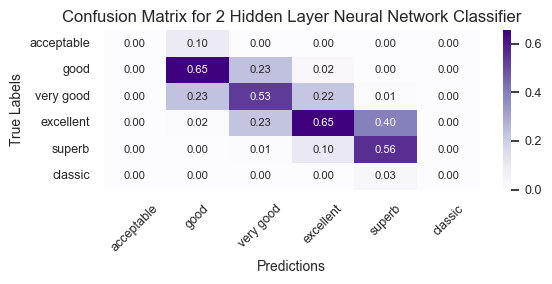

In [121]:
fig = plt.figure(figsize=(6, 3))
ax = sns.heatmap(conf_matrix, xticklabels=ratings, yticklabels=ratings, annot=True, cmap="Purples", fmt=",.2f", annot_kws={"size": 8}, )
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9, rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
ax.set_ylabel('True Labels', fontdict={'size': 10})
ax.set_xlabel('Predictions', fontdict={'size': 10})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=9)
plt.title('Confusion Matrix for 2 Hidden Layer Neural Network Classifier')
plt.tight_layout()
plt.show()

In [122]:
result_nn_2_layer = (training_time, accuracy_train['accuracy'], accuracy_test['accuracy'], conf_matrix, y_preds, y_pred_prob)

In [123]:
perf_results = pd.DataFrame([result_baseline, result_nn_1_layer, result_nn_2_layer], columns=['train time', 'accuracy_train', 'accuracy_test', 'conf_matrix', 'y_preds', 'y_pred_prob'])
perf_results.to_json('data/nn_perf_result.json')
perf_results

,train time,accuracy_train,accuracy_test,conf_matrix,y_preds,y_pred_prob
0,4.927340,0.525340,0.521328,"[[0.8125, 0.07708553326293559, 0.0061840120663...","[very good, very good, very good, very good, v...","[[0.007839160759560993, 0.0005244613421105278,..."
1,15.633201,0.597755,0.593439,"[[0.6666666666666666, 0.0640830027464144, 0.00...","[good, very good, excellent, excellent, good, ...","[[0.0029024223, 1.063068e-12, 0.040243227, 0.5..."
2,14.080483,0.604598,0.604763,"[[0.0, 0.09672131147540984, 0.0031454783748361...","[good, very good, excellent, excellent, very g...","[[0.009233806, 1.2001658e-08, 0.057791527, 0.5..."


## Conclusion

- The baseline model using LogisticRegression had an accuracy on the test dataset of $52.1\%$.
- The neural classifier with $1$ hidden layers and $108,038$ trainnable parameters achieved an accuracy on the test dataset of $59.3\%$.
- The neural classifier with $2$ hidden layers and $124,550$ trainnable parameters achieved an accuracy on the test dataset of $60.5\%$.

## Next
 - [Summary](summary.ipynb)